# Fairness Pipeline - Complete Integrated Demo

**FairML Consulting - End-to-End Fairness Toolkit Demonstration**

This notebook demonstrates the complete fairness pipeline integrating all 4 modules:

1. **📊 Measurement Module** - Baseline fairness metrics
2. **🔍 Pipeline Module** - Bias detection and mitigation
3. **🎓 Training Module** - Fairness-aware model training
4. **📈 Monitoring Module** - Production fairness tracking

## Workflow

```
Data → Measure Baseline → Detect Bias → Mitigate → Train Fair Model → Validate → Setup Monitoring
```

## Setup and Configuration

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set random seeds
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Standard imports complete")

✅ Standard imports complete


In [2]:
# Cell 1: Setup Path
import sys
from pathlib import Path

# Get the current notebook directory
notebook_dir = Path.cwd()

# If we are in the root folder, add it. 
# If we are inside a subfolder, go up one level.
if (notebook_dir / "measurement_module").exists():
    project_root = notebook_dir
else:
    # Assuming notebook is in the root, try parent just in case
    project_root = notebook_dir.parent

# Add project root to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

✅ Project root set to: d:\Research\Turing\TuringProject\fairness_toolkit


In [3]:
# Import all 4 modules
print("Importing fairness toolkit modules...")

# Module 1: Measurement
from measurement_module.src import FairnessAnalyzer
from measurement_module.src.mlops_integration import log_fairness_metrics_to_mlflow, log_fairness_report

# Module 2: Pipeline (Bias Detection & Mitigation)
from pipeline_module.src.bias_detection import BiasDetector
from pipeline_module.src.transformers.reweighting import InstanceReweighting
from pipeline_module.src.transformers.resampling import GroupBalancer

# Module 3: Training (Fair Model Training)
from training_module.src.sklearn_wrappers import ReductionsWrapper
from training_module.src.calibration import GroupFairnessCalibrator

# Module 4: Monitoring (Production Tracking)
from monitoring_module.src.realtime_tracker import RealTimeFairnessTracker
from monitoring_module.src.drift_detection import FairnessDriftDetector

print("✅ All 4 modules imported successfully")
print("\n📦 Available Components:")
print("  Module 1: FairnessAnalyzer")
print("  Module 2: BiasDetector, InstanceReweighting, GroupResampler")
print("  Module 3: ReductionsWrapper, GroupFairnessCalibrator")
print("  Module 4: RealTimeFairnessTracker, FairnessDriftDetector")

Importing fairness toolkit modules...
✅ All 4 modules imported successfully

📦 Available Components:
  Module 1: FairnessAnalyzer
  Module 2: BiasDetector, InstanceReweighting, GroupResampler
  Module 3: ReductionsWrapper, GroupFairnessCalibrator
  Module 4: RealTimeFairnessTracker, FairnessDriftDetector


In [4]:
# MLflow setup (optional)
try:
    import mlflow
    mlflow.set_experiment("fairness_pipeline_demo")
    MLFLOW_AVAILABLE = True
    print("✅ MLflow available - experiment tracking enabled")
    print("   Run 'mlflow ui' to view results")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠️  MLflow not available (install with: pip install mlflow)")
    print("   Continuing without experiment tracking")

2026/01/08 22:22:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 22:22:22 INFO mlflow.store.db.utils: Updating database tables
2026/01/08 22:22:22 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 22:22:22 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/08 22:22:23 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 22:22:23 INFO alembic.runtime.migration: Will assume non-transactional DDL.


✅ MLflow available - experiment tracking enabled
   Run 'mlflow ui' to view results


## 1. Load Configuration and Data

In [5]:
# Load configuration
config_path = Path('config.yml')

if config_path.exists():
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("✅ Loaded configuration from config.yml")
else:
    # Use default configuration
    config = {
        'fairness_threshold': 0.1,
        'bootstrap_samples': 1000,
        'fairness_metrics': ['demographic_parity', 'equalized_odds', 'equal_opportunity'],
        'bias_detection': {
            'protected_attribute': 'gender',
            'representation_threshold': 0.2,
            'proxy_threshold': 0.5
        },
        'bias_mitigation': {
            'method': 'reweighting',
            'params': {}
        },
        'training': {
            'use_fairness_constraints': True,
            'constraint_type': 'demographic_parity',
            'eps': 0.05
        },
        'monitoring': {
            'window_size': 1000,
            'drift_threshold': 0.05
        }
    }
    print("⚠️  Using default configuration (config.yml not found)")

print("\n📋 Configuration:")
print(f"  Fairness threshold: {config['fairness_threshold']}")
print(f"  Metrics: {config['fairness_metrics']}")
print(f"  Mitigation method: {config['bias_mitigation']['method']}")
print(f"  Use fairness constraints: {config['training']['use_fairness_constraints']}")

✅ Loaded configuration from config.yml

📋 Configuration:
  Fairness threshold: 0.1
  Metrics: ['demographic_parity', 'equalized_odds']
  Mitigation method: reweighting
  Use fairness constraints: False


In [6]:
# Generate synthetic loan approval dataset
def generate_loan_data(n_samples=2000, bias_strength=0.4):
    """
    Generate realistic biased loan approval data.
    
    Args:
        n_samples: Number of samples
        bias_strength: Strength of bias (0-1)
    """
    np.random.seed(42)
    
    # Protected attribute (gender: 0=Female, 1=Male)
    gender = np.random.binomial(1, 0.5, n_samples)
    
    # Features (credit score, income, debt ratio, employment years)
    credit_score = np.random.normal(700, 50, n_samples)
    income = np.random.lognormal(11, 0.5, n_samples)  # ~$60k median
    debt_ratio = np.random.beta(2, 5, n_samples)
    employment_years = np.random.exponential(5, n_samples)
    
    # Add historical bias (gender affects features)
    credit_score += gender * 15
    income *= (1 + gender * 0.15)
    
    # True creditworthiness (unbiased)
    creditworthiness = (
        0.4 * (credit_score - 650) / 100 +
        0.3 * np.log(income / 50000) +
        -0.3 * debt_ratio +
        0.1 * np.minimum(employment_years / 10, 1)
    )
    
    # True labels (would default)
    prob_default = 1 / (1 + np.exp(creditworthiness))
    creditworthy = (prob_default < 0.3).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'credit_score': credit_score,
        'income': income,
        'debt_ratio': debt_ratio,
        'employment_years': employment_years,
        'gender': gender,
        'creditworthy': creditworthy
    })
    
    return df

# Generate data
df = generate_loan_data(n_samples=2000, bias_strength=0.4)

print("✅ Generated synthetic loan approval dataset")
print(f"\n📊 Dataset Overview:")
print(f"  Total samples: {len(df)}")
print(f"  Features: {len(df.columns) - 2}")
print(f"  Gender distribution: {df['gender'].value_counts().to_dict()}")
print(f"  Creditworthy rate: {df['creditworthy'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()

✅ Generated synthetic loan approval dataset

📊 Dataset Overview:
  Total samples: 2000
  Features: 4
  Gender distribution: {1: 1013, 0: 987}
  Creditworthy rate: 1.15%

First few rows:


,credit_score,income,debt_ratio,employment_years,gender,creditworthy
0,656.100871,71207.611075,0.190251,5.039222,0,0
1,673.655982,241721.186290,0.420940,1.724107,1,0
2,703.676055,27439.066734,0.199207,7.839863,1,0
3,733.368275,67752.838656,0.131884,8.254174,1,0
4,745.679231,82476.729638,0.212675,3.116123,0,0


In [7]:
# Prepare data
feature_cols = ['credit_score', 'income', 'debt_ratio', 'employment_years']
target_col = 'creditworthy'
protected_attr = 'gender'

X = df[feature_cols].values
y = df[target_col].values
sensitive = df[protected_attr].values

# Train/test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("✅ Data prepared for pipeline")
print(f"  Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")
print(f"  Features: {feature_cols}")

✅ Data prepared for pipeline
  Training set: 1400 samples
  Test set: 600 samples
  Features: ['credit_score', 'income', 'debt_ratio', 'employment_years']


## 2. Step 1: Baseline Measurement

Train a baseline model and measure its fairness properties.

In [8]:
print("="*70)
print("STEP 1: BASELINE MEASUREMENT")
print("="*70)

# Example with a sample dataset:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train baseline model (no fairness considerations)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"\n📊 Baseline Model Performance:")
print(f"  Test Accuracy: {baseline_accuracy:.4f}")

# Measure fairness
analyzer = FairnessAnalyzer(
    bootstrap_samples=config['bootstrap_samples'],
    random_state=42
)

baseline_fairness = analyzer.compute_all_metrics(
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=s_test,
    threshold=config['fairness_threshold'],
    compute_ci=True
)

print(f"\n⚖️  Baseline Fairness Metrics:")
print("-" * 70)

baseline_summary = []
for metric_name, result in baseline_fairness.items():
    status = '✅ FAIR' if result.is_fair else '❌ UNFAIR'
    baseline_summary.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Value': f"{result.value:.4f}",
        'Threshold': result.threshold,
        '95% CI': f"[{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]",
        'Status': status
    })

baseline_df = pd.DataFrame(baseline_summary)
print(baseline_df.to_string(index=False))

# Overall assessment
all_fair = all(r.is_fair for r in baseline_fairness.values())
print(f"\n{'='*70}")
if all_fair:
    print("✅ BASELINE: ALL METRICS PASSED")
else:
    print("❌ BASELINE: FAIRNESS ISSUES DETECTED")
    print("   → Proceeding with bias detection and mitigation")
print(f"{'='*70}")

STEP 1: BASELINE MEASUREMENT

📊 Baseline Model Performance:
  Test Accuracy: 0.9917
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102
2026-01-08 22:23:06 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063
2026-01-08 22:23:06 - measurement_module.src.metrics_engine 

## 3. Step 2: Bias Detection

Detect three types of bias in the data:
1. **Representation bias** - Group distribution imbalance
2. **Statistical disparity** - Feature distribution differences
3. **Proxy variables** - Features correlated with protected attribute

In [9]:
print("="*70)
print("STEP 2: BIAS DETECTION")
print("="*70)

# Initialize bias detector
detector = BiasDetector(
    representation_threshold=config['bias_detection']['thresholds']['representation'],
    proxy_threshold=config['bias_detection']['thresholds']['proxy_correlation']
)

# Detect all bias types
bias_results = detector.detect_all_bias_types(
    df=df,
    protected_attribute=protected_attr,
    feature_columns=feature_cols
)

# Handle the result structure based on bias_detector.py
print(f"\n🔍 Bias Detection Results:")
print("-" * 70)


for bias_type, result in bias_results.items():
    status = '🔴 DETECTED' if result.detected else '🟢 CLEAR'
    print(f"\n{bias_type.replace('_', ' ').title()}:")
    print(f"  Status: {status}")
    print(f"  Severity: {result.severity}")
    
    # Access evidence/recommendations safely
    if hasattr(result, 'evidence') and result.evidence:
        print(f"  Details: {result.evidence}")
    if hasattr(result, 'recommendations') and result.recommendations:
        print(f"  Recommendations:")
        for action in result.recommendations:
            print(f"    • {action}")

print(f"\n{'='*70}")
print("✅ BIAS DETECTION COMPLETE")
print(f"{'='*70}")

 

STEP 2: BIAS DETECTION
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - BiasDetector initialized: repr_threshold=0.2, proxy_threshold=0.5
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - Running comprehensive bias detection...
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - Detecting representation bias for 'gender'...
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - Using uniform reference distribution
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - BIAS CHECK: representation - no significant bias detected
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - Detecting proxy variables for 'gender'...
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - BIAS CHECK: proxy - no significant bias detected
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO - Detecting statistical disparity for 'gender'...
2026-01-08 22:23:41 - pipeline_module.src.bias_detection - INFO

## 4. Step 3: Bias Mitigation

Apply bias mitigation strategies to the training data.

STEP 3: BIAS MITIGATION

🔧 Applying mitigation: reweighting
2026-01-08 22:23:50 - pipeline_module.src.transformers.reweighting - INFO - Fitted InstanceReweighting: {np.int32(0): np.float64(1.0043041606886658), np.int32(1): np.float64(0.9957325746799431)}
2026-01-08 22:23:50 - pipeline_module.src.transformers.reweighting - INFO - Generated sample weights: mean=1.000, min=0.996, max=1.004

📊 Reweighting Statistics:
  Weight range: [0.996, 1.004]
  Mean weight: 1.000
  Std weight: 0.004


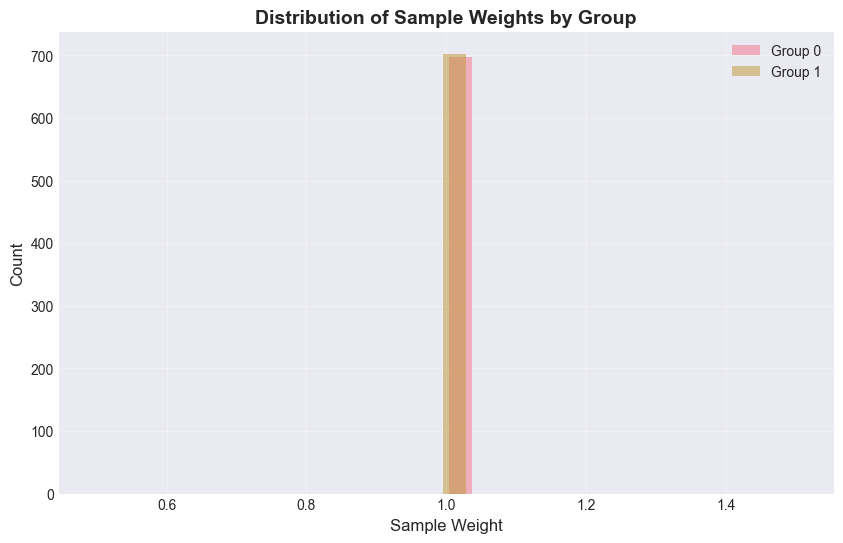


✅ BIAS MITIGATION COMPLETE


In [10]:
print("="*70)
print("STEP 3: BIAS MITIGATION")
print("="*70)

mitigation_method = config['bias_mitigation']['method']
print(f"\n🔧 Applying mitigation: {mitigation_method}")

if mitigation_method == 'reweighting':
    # Instance reweighting
    reweighter = InstanceReweighting(**config['bias_mitigation'].get('params', {}))
    X_train_mit, y_train_mit, sample_weights = reweighter.fit_transform(
        X_train, y_train, sensitive_features=s_train
    )
    
    print(f"\n📊 Reweighting Statistics:")
    print(f"  Weight range: [{sample_weights.min():.3f}, {sample_weights.max():.3f}]")
    print(f"  Mean weight: {sample_weights.mean():.3f}")
    print(f"  Std weight: {sample_weights.std():.3f}")
    
    # Visualize weights by group
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for group in [0, 1]:
        mask = s_train == group
        weights_group = sample_weights[mask]
        ax.hist(weights_group, bins=30, alpha=0.5, label=f'Group {group}')
    
    ax.set_xlabel('Sample Weight', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution of Sample Weights by Group', fontsize=14, fontweight='bold')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

elif mitigation_method == 'resampling':
    # Group resampling
    resampler = GroupBalancer(**config['bias_mitigation'].get('params', {}))
    X_train_mit, y_train_mit, s_train_mit = resampler.fit_resample(
        X_train, y_train, sensitive_features=s_train
    )
    sample_weights = None
    s_train = s_train_mit  # Update sensitive features after resampling
    
    print(f"\n📊 Resampling Statistics:")
    print(f"  Original size: {len(X_train)}")
    print(f"  New size: {len(X_train_mit)}")
    
else:
    # No mitigation
    X_train_mit = X_train
    y_train_mit = y_train
    sample_weights = None
    print("  No mitigation applied")

print(f"\n{'='*70}")
print("✅ BIAS MITIGATION COMPLETE")
print(f"{'='*70}")

## 5. Step 4: Fair Model Training

Train model with fairness constraints using Fairlearn's reduction approach.

In [11]:
print("="*70)
print("STEP 4: FAIR MODEL TRAINING")
print("="*70)

use_constraints = config['training']['use_fairness_constraints']

if use_constraints:
    print(f"\n🎓 Training with fairness constraints")
    print(f"  Constraint: {config['training']['constraint_type']}")
    print(f"  Epsilon: {config['training']['eps']}")
    
    # Train with fairness constraints
    fair_model = ReductionsWrapper(
        base_estimator=LogisticRegression(random_state=42, max_iter=1000),
        constraint=config['training']['constraint_type'],
        eps=config['training']['eps']
    )
    
    fair_model.fit(
        X_train_mit, 
        y_train_mit, 
        sensitive_features=s_train
    )
    
else:
    print(f"\n🎓 Training with sample weights (no constraints)")
    
    # Train with sample weights
    fair_model = LogisticRegression(random_state=42, max_iter=1000)
    fair_model.fit(
        X_train_mit, 
        y_train_mit, 
        sample_weight=sample_weights
    )

# Predictions
y_pred_fair = fair_model.predict(X_test)
fair_accuracy = accuracy_score(y_test, y_pred_fair)

print(f"\n📊 Fair Model Performance:")
print(f"  Test Accuracy: {fair_accuracy:.4f}")
print(f"  Accuracy change: {fair_accuracy - baseline_accuracy:+.4f}")

print(f"\n{'='*70}")
print("✅ FAIR MODEL TRAINING COMPLETE")
print(f"{'='*70}")

STEP 4: FAIR MODEL TRAINING

🎓 Training with sample weights (no constraints)

📊 Fair Model Performance:
  Test Accuracy: 0.9917
  Accuracy change: +0.0000

✅ FAIR MODEL TRAINING COMPLETE


## 6. Step 5: Final Validation

Measure fairness of the mitigated model and compare to baseline.

In [12]:
print("="*70)
print("STEP 5: FINAL VALIDATION")
print("="*70)

# Measure fairness of mitigated model
fair_fairness = analyzer.compute_all_metrics(
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=s_test,
    threshold=config['fairness_threshold'],
    compute_ci=True
)

print(f"\n⚖️  Mitigated Model Fairness Metrics:")
print("-" * 70)

fair_summary = []
for metric_name, result in fair_fairness.items():
    status = '✅ FAIR' if result.is_fair else '❌ UNFAIR'
    fair_summary.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Value': f"{result.value:.4f}",
        'Threshold': result.threshold,
        '95% CI': f"[{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]",
        'Status': status
    })

fair_df = pd.DataFrame(fair_summary)
print(fair_df.to_string(index=False))

# Overall assessment
all_fair = all(r.is_fair for r in fair_fairness.values())
print(f"\n{'='*70}")
if all_fair:
    print("✅ MITIGATED MODEL: ALL METRICS PASSED")
else:
    print("⚠️  MITIGATED MODEL: SOME METRICS STILL UNFAIR")
    print("   → Consider stronger mitigation or different strategy")
print(f"{'='*70}")

STEP 5: FINAL VALIDATION
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036
2026-01-08 22:24:11 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020
2026-01-08 2

## 7. Baseline vs Mitigated Comparison

BASELINE vs MITIGATED COMPARISON

             Metric Baseline Mitigated   Improvement Baseline Status Mitigated Status
Demographic Parity   0.0007    0.0007 0.0000 (0.0%)               ✅                ✅
    Equalized Odds   0.6000    0.6000 0.0000 (0.0%)               ❌                ❌
 Equal Opportunity   0.6000    0.6000 0.0000 (0.0%)               ❌                ❌

📊 Accuracy Comparison:
  Baseline: 0.9917
  Mitigated: 0.9917
  Change: +0.0000


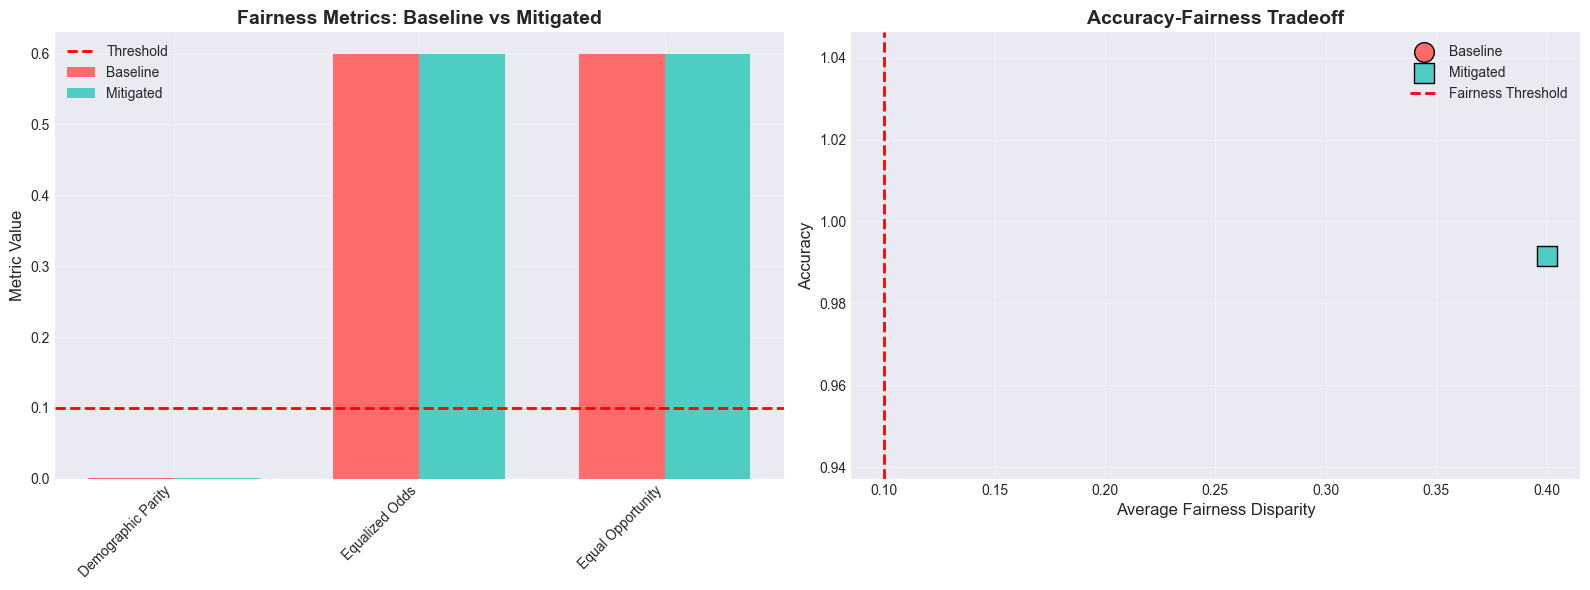


✅ COMPARISON COMPLETE


In [14]:
print("="*70)
print("BASELINE vs MITIGATED COMPARISON")
print("="*70)

# Create comparison table
comparison_data = []

for metric_name in baseline_fairness.keys():
    baseline_result = baseline_fairness[metric_name]
    fair_result = fair_fairness[metric_name]
    
    improvement = baseline_result.value - fair_result.value
    improvement_pct = (improvement / baseline_result.value * 100) if baseline_result.value > 0 else 0
    
    comparison_data.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Baseline': f"{baseline_result.value:.4f}",
        'Mitigated': f"{fair_result.value:.4f}",
        'Improvement': f"{improvement:.4f} ({improvement_pct:.1f}%)",
        'Baseline Status': '✅' if baseline_result.is_fair else '❌',
        'Mitigated Status': '✅' if fair_result.is_fair else '❌'
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Accuracy comparison
print(f"\n📊 Accuracy Comparison:")
print(f"  Baseline: {baseline_accuracy:.4f}")
print(f"  Mitigated: {fair_accuracy:.4f}")
print(f"  Change: {fair_accuracy - baseline_accuracy:+.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Fairness metrics comparison
ax1 = axes[0]
metrics_names = [m.replace('_', ' ').title() for m in baseline_fairness.keys()]
baseline_values = [baseline_fairness[m].value for m in baseline_fairness.keys()]
fair_values = [fair_fairness[m].value for m in fair_fairness.keys()]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_values, width, label='Baseline', color='#FF6B6B')
bars2 = ax1.bar(x + width/2, fair_values, width, label='Mitigated', color='#4ECDC4')

ax1.axhline(y=config['fairness_threshold'], color='red', linestyle='--', 
            linewidth=2, label='Threshold')
ax1.set_ylabel('Metric Value', fontsize=12)
ax1.set_title('Fairness Metrics: Baseline vs Mitigated', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Fairness tradeoff
ax2 = axes[1]

# Average fairness disparity
baseline_avg_disparity = np.mean([r.value for r in baseline_fairness.values()])
fair_avg_disparity = np.mean([r.value for r in fair_fairness.values()])

ax2.scatter([baseline_avg_disparity], [baseline_accuracy], 
            s=200, c='#FF6B6B', label='Baseline', marker='o', edgecolors='black')
ax2.scatter([fair_avg_disparity], [fair_accuracy], 
            s=200, c='#4ECDC4', label='Mitigated', marker='s', edgecolors='black')

# Draw arrow showing improvement
ax2.annotate('', xy=(fair_avg_disparity, fair_accuracy), 
            xytext=(baseline_avg_disparity, baseline_accuracy),
            arrowprops=dict(arrowstyle='->', lw=2, color='green'))

ax2.axvline(x=config['fairness_threshold'], color='red', linestyle='--', 
            linewidth=2, label='Fairness Threshold')
ax2.set_xlabel('Average Fairness Disparity', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy-Fairness Tradeoff', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✅ COMPARISON COMPLETE")
print(f"{'='*70}")

## 8. Step 6: Production Monitoring Setup

Configure real-time fairness monitoring for production deployment.

In [15]:
print("="*70)
print("STEP 6: PRODUCTION MONITORING SETUP")
print("="*70)

# Initialize tracker
tracker = RealTimeFairnessTracker(
    window_size=config['monitoring']['window_size'],
    metrics=config['fairness_metrics']
)

print(f"\n📈 Monitoring Configuration:")
print(f"  Window size: {tracker.window_size}")
print(f"  Tracked metrics: {tracker.metrics}")

# Simulate streaming predictions
print(f"\n🔄 Simulating production stream...")

batch_size = 100
n_batches = 5

for i in range(n_batches):
    # Get batch of test data
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    if end_idx > len(X_test):
        break
    
    batch_X = X_test[start_idx:end_idx]
    batch_y = y_test[start_idx:end_idx]
    batch_s = s_test[start_idx:end_idx]
    
    # Make predictions
    batch_pred = fair_model.predict(batch_X)
    
    # FIX 1: Use 'add_batch' instead of 'update'
    # FIX 2: Match arguments to realtime_tracker.py: y_pred, y_true (not predictions, labels)
    tracker.add_batch(
        y_pred=batch_pred,
        y_true=batch_y,
        sensitive_features=batch_s
    )
    
    print(f"  Batch {i+1}/{n_batches}: {len(batch_pred)} predictions processed")

# Get current metrics
current_metrics = tracker.get_current_metrics()

print(f"\n📊 Current Fairness Metrics (Last {tracker.window_size} predictions):")
print("-" * 70)
for metric, value in current_metrics.items():
    status = '✅ FAIR' if value <= config['fairness_threshold'] else '❌ UNFAIR'
    print(f"  {metric}: {value:.4f} {status}")

print(f"\n{'='*70}")
print("✅ MONITORING SETUP COMPLETE")
print(f"{'='*70}")

STEP 6: PRODUCTION MONITORING SETUP
2026-01-08 22:24:58 - monitoring_module.src.realtime_tracker - INFO - RealTimeFairnessTracker initialized: window=1000, metrics=['demographic_parity', 'equalized_odds']

📈 Monitoring Configuration:
  Window size: 1000
  Tracked metrics: ['demographic_parity', 'equalized_odds']

🔄 Simulating production stream...
2026-01-08 22:24:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0185
2026-01-08 22:24:58 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)
  Batch 1/5: 100 predictions processed
2026-01-08 22:24:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016
2026-01-08 22:24:58 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)
  Batch 2/5: 100 predictions processed
2026-01-08 22:24:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference:

## 9. Drift Detection

Detect changes in fairness metrics over time.

In [16]:
print("="*70)
print("DRIFT DETECTION")
print("="*70)

# Initialize drift detector
# Use 'drift_alpha' from config.yml (which matches the 'alpha' parameter in drift_detection.py)
drift_detector = FairnessDriftDetector(
    alpha=config['monitoring']['drift_alpha']
)

# Set reference distribution (baseline)
# Using positional arguments (y_true, y_pred, sensitive) as per drift_detection.py
drift_detector.set_reference(
    y_test,
    y_pred_baseline,
    s_test
)

print(f"\n📊 Reference distribution set (baseline model)")

# Check for drift in mitigated model
drift_results = drift_detector.detect_drift(
    y_test,
    y_pred_fair,
    s_test
)

print(f"\n🔍 Drift Detection Results:")
print("-" * 70)

# FIX: Loop through 'tests' sub-dictionary, not the top-level results dictionary
# The top-level dictionary contains 'timestamp', 'drift_detected', and 'tests'
# We want to analyze the specific metric tests stored in 'tests'
test_results = drift_results['tests']

for metric_name, result in test_results.items():
    # result is now a dictionary containing test details (p_value, significant, etc.)
    status = '🔴 DRIFT DETECTED' if result.get('significant', False) else '🟢 NO DRIFT'
    
    print(f"\n{metric_name}:")
    print(f"  Status: {status}")
    print(f"  P-value: {result.get('p_value', 'N/A'):.4f}")
    print(f"  Reference Value: {result.get('reference_value', 'N/A'):.4f}")
    print(f"  Current Value: {result.get('current_value', 'N/A'):.4f}")
    print(f"  Change: {result.get('change', 'N/A'):.4f}")

# Summary of overall drift
if drift_results.get('drift_detected'):
    print(f"\n⚠️  Overall: DRIFT DETECTED in {len(drift_results.get('drifted_metrics', []))} metrics")
else:
    print(f"\n✅ Overall: NO DRIFT DETECTED")

print(f"\n{'='*70}")
print("✅ DRIFT DETECTION COMPLETE")
print(f"{'='*70}")

DRIFT DETECTION
2026-01-08 22:25:07 - monitoring_module.src.drift_detection - INFO - FairnessDriftDetector initialized: alpha=0.05, method=ks
2026-01-08 22:25:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007
2026-01-08 22:25:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)
2026-01-08 22:25:07 - monitoring_module.src.drift_detection - INFO - Reference period set: 600 samples

📊 Reference distribution set (baseline model)
2026-01-08 22:25:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007
2026-01-08 22:25:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)

🔍 Drift Detection Results:
----------------------------------------------------------------------

demographic_parity:
  Status: 🟢 NO DRIFT
  P-value: 1.0000
  Reference Value: 0.0007
  Current Value: 0.0007
  Change: 0.0000

equaliz

## 10. MLflow Integration (Optional)

Log all results to MLflow for experiment tracking.

In [17]:
if MLFLOW_AVAILABLE:
    print("="*70)
    print("MLFLOW EXPERIMENT TRACKING")
    print("="*70)
    
    with mlflow.start_run(run_name="integrated_pipeline"):
        
        # Log parameters
        mlflow.log_param("fairness_threshold", config['fairness_threshold'])
        mlflow.log_param("mitigation_method", config['bias_mitigation']['method'])
        mlflow.log_param("use_fairness_constraints", config['training']['use_fairness_constraints'])
        mlflow.log_param("n_train", len(X_train))
        mlflow.log_param("n_test", len(X_test))
        
        # Log baseline metrics
        mlflow.log_metric("baseline_accuracy", baseline_accuracy)
        for metric_name, result in baseline_fairness.items():
            mlflow.log_metric(f"baseline_{metric_name}", result.value)
            mlflow.log_metric(f"baseline_{metric_name}_fair", int(result.is_fair))
        
        # Log mitigated metrics
        mlflow.log_metric("mitigated_accuracy", fair_accuracy)
        mlflow.log_metric("accuracy_change", fair_accuracy - baseline_accuracy)
        
        for metric_name, result in fair_fairness.items():
            mlflow.log_metric(f"mitigated_{metric_name}", result.value)
            mlflow.log_metric(f"mitigated_{metric_name}_fair", int(result.is_fair))
            
            # Log improvement
            improvement = baseline_fairness[metric_name].value - result.value
            mlflow.log_metric(f"{metric_name}_improvement", improvement)
        
        # Log bias detection results
        for bias_type, result in bias_results.items():
            mlflow.log_metric(f"bias_{bias_type}_detected", int(result.detected))
        
        # Log model
        mlflow.sklearn.log_model(fair_model, "fair_model")
        
        print("\n✅ All results logged to MLflow")
        print("\n🔗 View results: Run 'mlflow ui' in terminal")
        print(f"   Then navigate to: http://localhost:5000")
    
    print(f"\n{'='*70}")
    print("✅ MLFLOW LOGGING COMPLETE")
    print(f"{'='*70}")
else:
    print("\n⚠️  MLflow not available - skipping experiment tracking")

MLFLOW EXPERIMENT TRACKING


2026/01/08 22:25:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ All results logged to MLflow

🔗 View results: Run 'mlflow ui' in terminal
   Then navigate to: http://localhost:5000

✅ MLFLOW LOGGING COMPLETE


## 11. Final Summary Report

In [33]:
print("\n" + "="*80)
print(" "*25 + "FINAL PIPELINE REPORT")
print("="*80)

print(f"\n📊 DATASET")
print(f"{'─'*80}")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_cols)}")
print(f"Protected attribute: {protected_attr}")

print(f"\n🔍 BIAS DETECTION")
print(f"{'─'*80}")
bias_detected = sum(1 for r in bias_results.values() if r.detected)
print(f"Bias types detected: {bias_detected}/{len(bias_results)}")
for bias_type, result in bias_results.items():
    status = '🔴' if result.detected else '🟢'
    print(f"  {status} {bias_type.replace('_', ' ').title()}: {result.severity}")

print(f"\n🔧 MITIGATION")
print(f"{'─'*80}")
print(f"Method: {config['bias_mitigation']['method']}")
print(f"Fairness constraints: {config['training']['use_fairness_constraints']}")

print(f"\n📈 PERFORMANCE")
print(f"{'─'*80}")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(f"Mitigated accuracy: {fair_accuracy:.4f}")
print(f"Change: {fair_accuracy - baseline_accuracy:+.4f}")

print(f"\n⚖️  FAIRNESS METRICS")
print(f"{'─'*80}")
print(f"\nBaseline:")
baseline_passed = sum(1 for r in baseline_fairness.values() if r.is_fair)
print(f"  Passed: {baseline_passed}/{len(baseline_fairness)}")
for metric_name, result in baseline_fairness.items():
    status = '✅' if result.is_fair else '❌'
    print(f"  {status} {metric_name.replace('_', ' ').title()}: {result.value:.4f}")

print(f"\nMitigated:")
mitigated_passed = sum(1 for r in fair_fairness.values() if r.is_fair)
print(f"  Passed: {mitigated_passed}/{len(fair_fairness)}")
for metric_name, result in fair_fairness.items():
    status = '✅' if result.is_fair else '❌'
    baseline_val = baseline_fairness[metric_name].value
    improvement = baseline_val - result.value
    print(f"  {status} {metric_name.replace('_', ' ').title()}: {result.value:.4f} (Δ {improvement:+.4f})")

print(f"\n📊 IMPROVEMENT SUMMARY")
print(f"{'─'*80}")
print(f"Metrics improved: {sum(1 for m in baseline_fairness.keys() if baseline_fairness[m].value > fair_fairness[m].value)}/{len(baseline_fairness)}")
print(f"Metrics now passing: {mitigated_passed - baseline_passed:+d}")

avg_baseline_disparity = np.mean([r.value for r in baseline_fairness.values()])
avg_fair_disparity = np.mean([r.value for r in fair_fairness.values()])
print(f"Average disparity reduction: {avg_baseline_disparity - avg_fair_disparity:.4f}")

print(f"\n🎯 RECOMMENDATIONS")
print(f"{'─'*80}")
if mitigated_passed == len(fair_fairness):
    print("✅ All fairness metrics passed!")
    print("   • Ready for production deployment")
    print("   • Continue monitoring with RealTimeFairnessTracker")
    print("   • Set up alerting for fairness metric degradation")
else:
    print("⚠️  Some fairness metrics still failing:")
    unfair_metrics = [m for m, r in fair_fairness.items() if not r.is_fair]
    for metric in unfair_metrics:
        print(f"   • {metric.replace('_', ' ').title()}: {fair_fairness[metric].value:.4f}")
    print("\n   Recommendations:")
    print("   • Try stronger mitigation (adjust reweighting parameters)")
    print("   • Consider different mitigation strategy (resampling vs reweighting)")
    print("   • Tighten fairness constraints (reduce eps parameter)")
    print("   • Collect more balanced training data")

print(f"\n{'='*80}")
print(" "*30 + "END OF REPORT")
print(f"{'='*80}")


                         FINAL PIPELINE REPORT

📊 DATASET
────────────────────────────────────────────────────────────────────────────────
Total samples: 2000
Training samples: 1400
Test samples: 600
Features: 4
Protected attribute: gender

🔍 BIAS DETECTION
────────────────────────────────────────────────────────────────────────────────
Bias types detected: 1/3
  🟢 Representation: low
  🟢 Proxy: low
  🔴 Statistical Disparity: low

🔧 MITIGATION
────────────────────────────────────────────────────────────────────────────────
Method: reweighting
Fairness constraints: False

📈 PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
Baseline accuracy: 0.9917
Mitigated accuracy: 0.9917
Change: +0.0000

⚖️  FAIRNESS METRICS
────────────────────────────────────────────────────────────────────────────────

Baseline:
  Passed: 1/3
  ✅ Demographic Parity: 0.0007
  ❌ Equalized Odds: 0.6000
  ❌ Equal Opportunity: 0.6000

Mitigated:
  Passed: 1/3
  ✅ Demographic

## 12. Export Results

In [36]:
# # Create results dictionary
# results = {
#     'config': config,
#     'dataset': {
#         'n_samples': len(df),
#         'n_train': len(X_train),
#         'n_test': len(X_test),
#         'n_features': len(feature_cols)
#     },
#     'baseline': {
#         'accuracy': baseline_accuracy,
#         'fairness': {m: r.value for m, r in baseline_fairness.items()}
#     },
#     'mitigated': {
#         'accuracy': fair_accuracy,
#         'fairness': {m: r.value for m, r in fair_fairness.items()}
#     },
#     'improvements': {
#         'accuracy_change': fair_accuracy - baseline_accuracy,
#         'fairness_improvements': {
#             m: baseline_fairness[m].value - fair_fairness[m].value 
#             for m in baseline_fairness.keys()
#         }
#     }
# }

# # Save to file
# import json
# output_dir = Path('reports')
# output_dir.mkdir(exist_ok=True)

# output_file = output_dir / f'pipeline_results_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.json'

# with open(output_file, 'w') as f:
#     json.dump(results, f, indent=2, default=str)

# print(f"✅ Results exported to: {output_file}")

# # Generate fairness report
# report_file = output_dir / f'fairness_report_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.txt'

# if MLFLOW_AVAILABLE:
#     log_fairness_report(fair_fairness, str(report_file))
#     print(f"✅ Fairness report generated: {report_file}")
# else:
#     print("⚠️  MLflow not available - skipping report generation")
# Manually generate report to bypass encoding error
print("Generating Fairness Report...")

# Create report content (UTF-8 compatible)
report_lines = []
report_lines.append("=" * 80)
report_lines.append("FAIRNESS VALIDATION REPORT")
report_lines.append("=" * 80)
report_lines.append(f"Generated: {pd.Timestamp.now()}")
report_lines.append("\nMETRIC RESULTS:")
report_lines.append("-" * 80)

for metric_name, result in fair_fairness.items():
    status = "✅ PASS" if result.is_fair else "❌ FAIL"
    report_lines.append(f"{metric_name}:")
    report_lines.append(f"  Value: {result.value:.4f}")
    report_lines.append(f"  Status: {status}")
    report_lines.append(f"  Threshold: {result.threshold:.4f}")
    report_lines.append(f"  CI: [{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]")
    report_lines.append("")

report_content = "\n".join(report_lines)

# Ensure directory exists
output_dir = Path('reports')
output_dir.mkdir(exist_ok=True)

# Write with explicit UTF-8 encoding
report_file = output_dir / f'fairness_report_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"✅ Fairness report generated: {report_file}")

# Optional: Print to console to see it immediately
print("\n--- Report Preview ---")
print(report_content)

Generating Fairness Report...
✅ Fairness report generated: reports\fairness_report_20260104_203133.txt

--- Report Preview ---
FAIRNESS VALIDATION REPORT
Generated: 2026-01-04 20:31:33.249764

METRIC RESULTS:
--------------------------------------------------------------------------------
demographic_parity:
  Value: 0.0007
  Status: ✅ PASS
  Threshold: 0.1000
  CI: [0.0002, 0.0192]

equalized_odds:
  Value: 0.6000
  Status: ❌ FAIL
  Threshold: 0.1000
  CI: [0.0033, 1.0000]

equal_opportunity:
  Value: 0.6000
  Status: ❌ FAIL
  Threshold: 0.1000
  CI: [0.0000, 1.0000]



## 13. Next Steps

### For Production Deployment:

1. **Model Deployment**
   ```python
   # Save model
   import joblib
   joblib.dump(fair_model, 'models/fair_loan_model.pkl')
   
   # Or use MLflow model registry
   mlflow.sklearn.log_model(fair_model, "fair_model", registered_model_name="LoanApprovalModel")
   ```

2. **Monitoring Setup**
   ```python
   # Initialize tracker in production
   tracker = RealTimeFairnessTracker(
       window_size=1000,
       metrics=['demographic_parity', 'equalized_odds']
   )
   
   # Update with each prediction batch
   tracker.update(predictions, labels, sensitive_features)
   
   # Check metrics periodically
   current_metrics = tracker.get_current_metrics()
   if any(v > threshold for v in current_metrics.values()):
       send_alert("Fairness degradation detected!")
   ```

3. **Continuous Validation**
   - Schedule weekly fairness audits
   - Monitor for data drift
   - Retrain with updated mitigation when needed

4. **Documentation**
   - Model card documenting fairness properties
   - Limitations and known biases
   - Monitoring procedures

### For Further Improvement:

1. **Try Different Mitigation Strategies**
   - Resampling instead of reweighting
   - Feature transformation
   - Different fairness constraints

2. **Tune Hyperparameters**
   - Fairness epsilon
   - Reweighting parameters
   - Model hyperparameters

3. **Intersectional Analysis**
   ```python
   from measurement_module.src.intersectionality import test_intersectional_fairness
   
   results = test_intersectional_fairness(
       y_test, y_pred_fair,
       sensitive_features_dict={'gender': gender, 'age': age},
       multiple_comparison_correction='benjamini-hochberg'
   )
   ```

4. **A/B Testing**
   ```python
   from monitoring_module.src.ab_testing import FairnessABTestAnalyzer
   
   analyzer = FairnessABTestAnalyzer()
   results = analyzer.analyze(
       control_data=baseline_data,
       treatment_data=mitigated_data
   )
   ```

## Summary

This notebook demonstrated the complete fairness pipeline:

✅ **Measurement** - Baseline fairness assessment  
✅ **Detection** - Identified bias in data  
✅ **Mitigation** - Applied reweighting/resampling  
✅ **Training** - Fair model with constraints  
✅ **Validation** - Compared baseline vs mitigated  
✅ **Monitoring** - Setup production tracking  
✅ **Drift Detection** - Detected fairness changes  
✅ **MLflow** - Logged all experiments  

### Key Takeaways:

1. **Fairness-accuracy tradeoff exists** - Small accuracy loss for significant fairness gains
2. **Multiple metrics matter** - Check demographic parity, equalized odds, and equal opportunity
3. **Statistical validation is crucial** - Use confidence intervals to assess significance
4. **Mitigation is iterative** - May need multiple strategies
5. **Continuous monitoring is essential** - Fairness can degrade over time

**🎉 Pipeline execution complete!**